# Raw Frequency Data → Master Curve

Apply manual shift factors to build a mastercurve and fit RheoJAX models.

In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports
Use raw multi-temperature frequency sweeps and apply RheoJAX mastercurve shifting with PyVisco shift factors.

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fractional_maxwell_model import FractionalMaxwellModel
from rheojax.models.generalized_maxwell import GeneralizedMaxwell
from rheojax.pipeline.base import Pipeline
from rheojax.transforms.mastercurve import Mastercurve

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)
import arviz as az


INFO:2025-12-07 17:28:23,946:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)


Loading rheojax version 0.4.0


/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/piblin_jax/__init__.py:28: UserWarning: GPU acceleration is only available on Linux with CUDA 12+. Using JAX in CPU mode.
  from . import backend, data, dataio, transform


Found 'auto' as default backend, checking available backends


Matplotlib is available, defining as default backend


arviz_base available, exposing its functions as part of arviz.preview


arviz_stats available, exposing its functions as part of arviz.preview


arviz_plots available, exposing its functions as part of arviz.preview


## Load raw sweeps and shift factors

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'pyvisco' / 'freq_raw'
raw_df = pd.read_excel(DATA_DIR / 'freq_Eplexor_raw.xls')
shift_df = pd.read_csv(DATA_DIR / 'freq_Eplexor_raw__shift_factors.csv')
shift_df.columns = shift_df.columns.str.strip()

# Drop header row (units) and coerce numeric
raw_clean = raw_df[pd.to_numeric(raw_df['Nr'], errors='coerce').notna()].copy()
raw_clean['T'] = raw_clean['T'].astype(float)

# Build RheoData per temperature
datasets = []
for temp_c, frame in raw_clean.groupby('T'):
    omega = 2 * np.pi * frame['f'].astype(float).to_numpy()
    Gp = frame["E'"] .astype(float).to_numpy()
    Gpp = frame["E''"].astype(float).to_numpy()
    data = RheoData(
        x=omega,
        y=Gp + 1j * Gpp,
        x_units='rad/s',
        y_units='MPa',
        domain='oscillation',
        metadata={'temperature': temp_c + 273.15, 'test_mode': 'oscillation'}
    )
    datasets.append(data)

# Manual shift factors from PyVisco table
shift_clean = shift_df.iloc[1:].copy()
shift_clean['T'] = shift_clean['T'].astype(float) + 273.15
shift_clean['log_aT'] = shift_clean['log_aT'].replace('-', 0).astype(float)
manual_shifts = {float(T): float(10 ** log_aT) for T, log_aT in zip(shift_clean['T'], shift_clean['log_aT'])}
ref_temp = float(shift_clean['T'].iloc[0])

mc = Mastercurve(reference_temp=ref_temp, method='manual', auto_shift=False)
mc.set_manual_shifts(manual_shifts)
master, shift_factors = mc.create_mastercurve(datasets, return_shifts=True)

print(f"Mastercurve built with {len(datasets)} temperatures → {len(master.x)} points")
shift_factors


Mastercurve built with 155 temperatures → 210 points


{223.1137: 1.0,
 223.14329999999998: 1.0,
 223.1735: 1.0,
 223.18829999999997: 1.0,
 223.1888: 1.0,
 223.3524: 1.0,
 223.36649999999997: 1.0,
 223.36699999999996: 1.0,
 230.55749999999998: 1.0,
 230.58739999999997: 1.0,
 230.60219999999998: 1.0,
 230.6024: 1.0,
 230.60269999999997: 1.0,
 230.6171: 1.0,
 230.61759999999998: 1.0,
 230.63179999999997: 1.0,
 230.6323: 1.0,
 238.1504: 1.0,
 238.15059999999997: 1.0,
 238.16539999999998: 1.0,
 238.16549999999998: 1.0,
 238.1658: 1.0,
 238.1803: 1.0,
 238.18039999999996: 1.0,
 238.195: 1.0,
 245.6306: 1.0,
 245.65999999999997: 1.0,
 245.66049999999998: 1.0,
 245.67499999999998: 1.0,
 245.6752: 1.0,
 245.67569999999998: 1.0,
 245.69019999999998: 1.0,
 245.70479999999998: 1.0,
 253.18769999999998: 1.0,
 253.20279999999997: 1.0,
 253.21729999999997: 1.0,
 253.21779999999998: 1.0,
 253.2181: 1.0,
 253.2326: 1.0,
 253.23289999999997: 1.0,
 253.23299999999998: 1.0,
 253.24779999999998: 1.0,
 260.67449999999997: 1.0,
 260.6747: 1.0,
 260.6898: 1.0,
 

## Plot raw vs shifted curves

/var/folders/rq/lgpr8fvj349cr_wvkzv99md80000gp/T/ipykernel_28415/1042397435.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


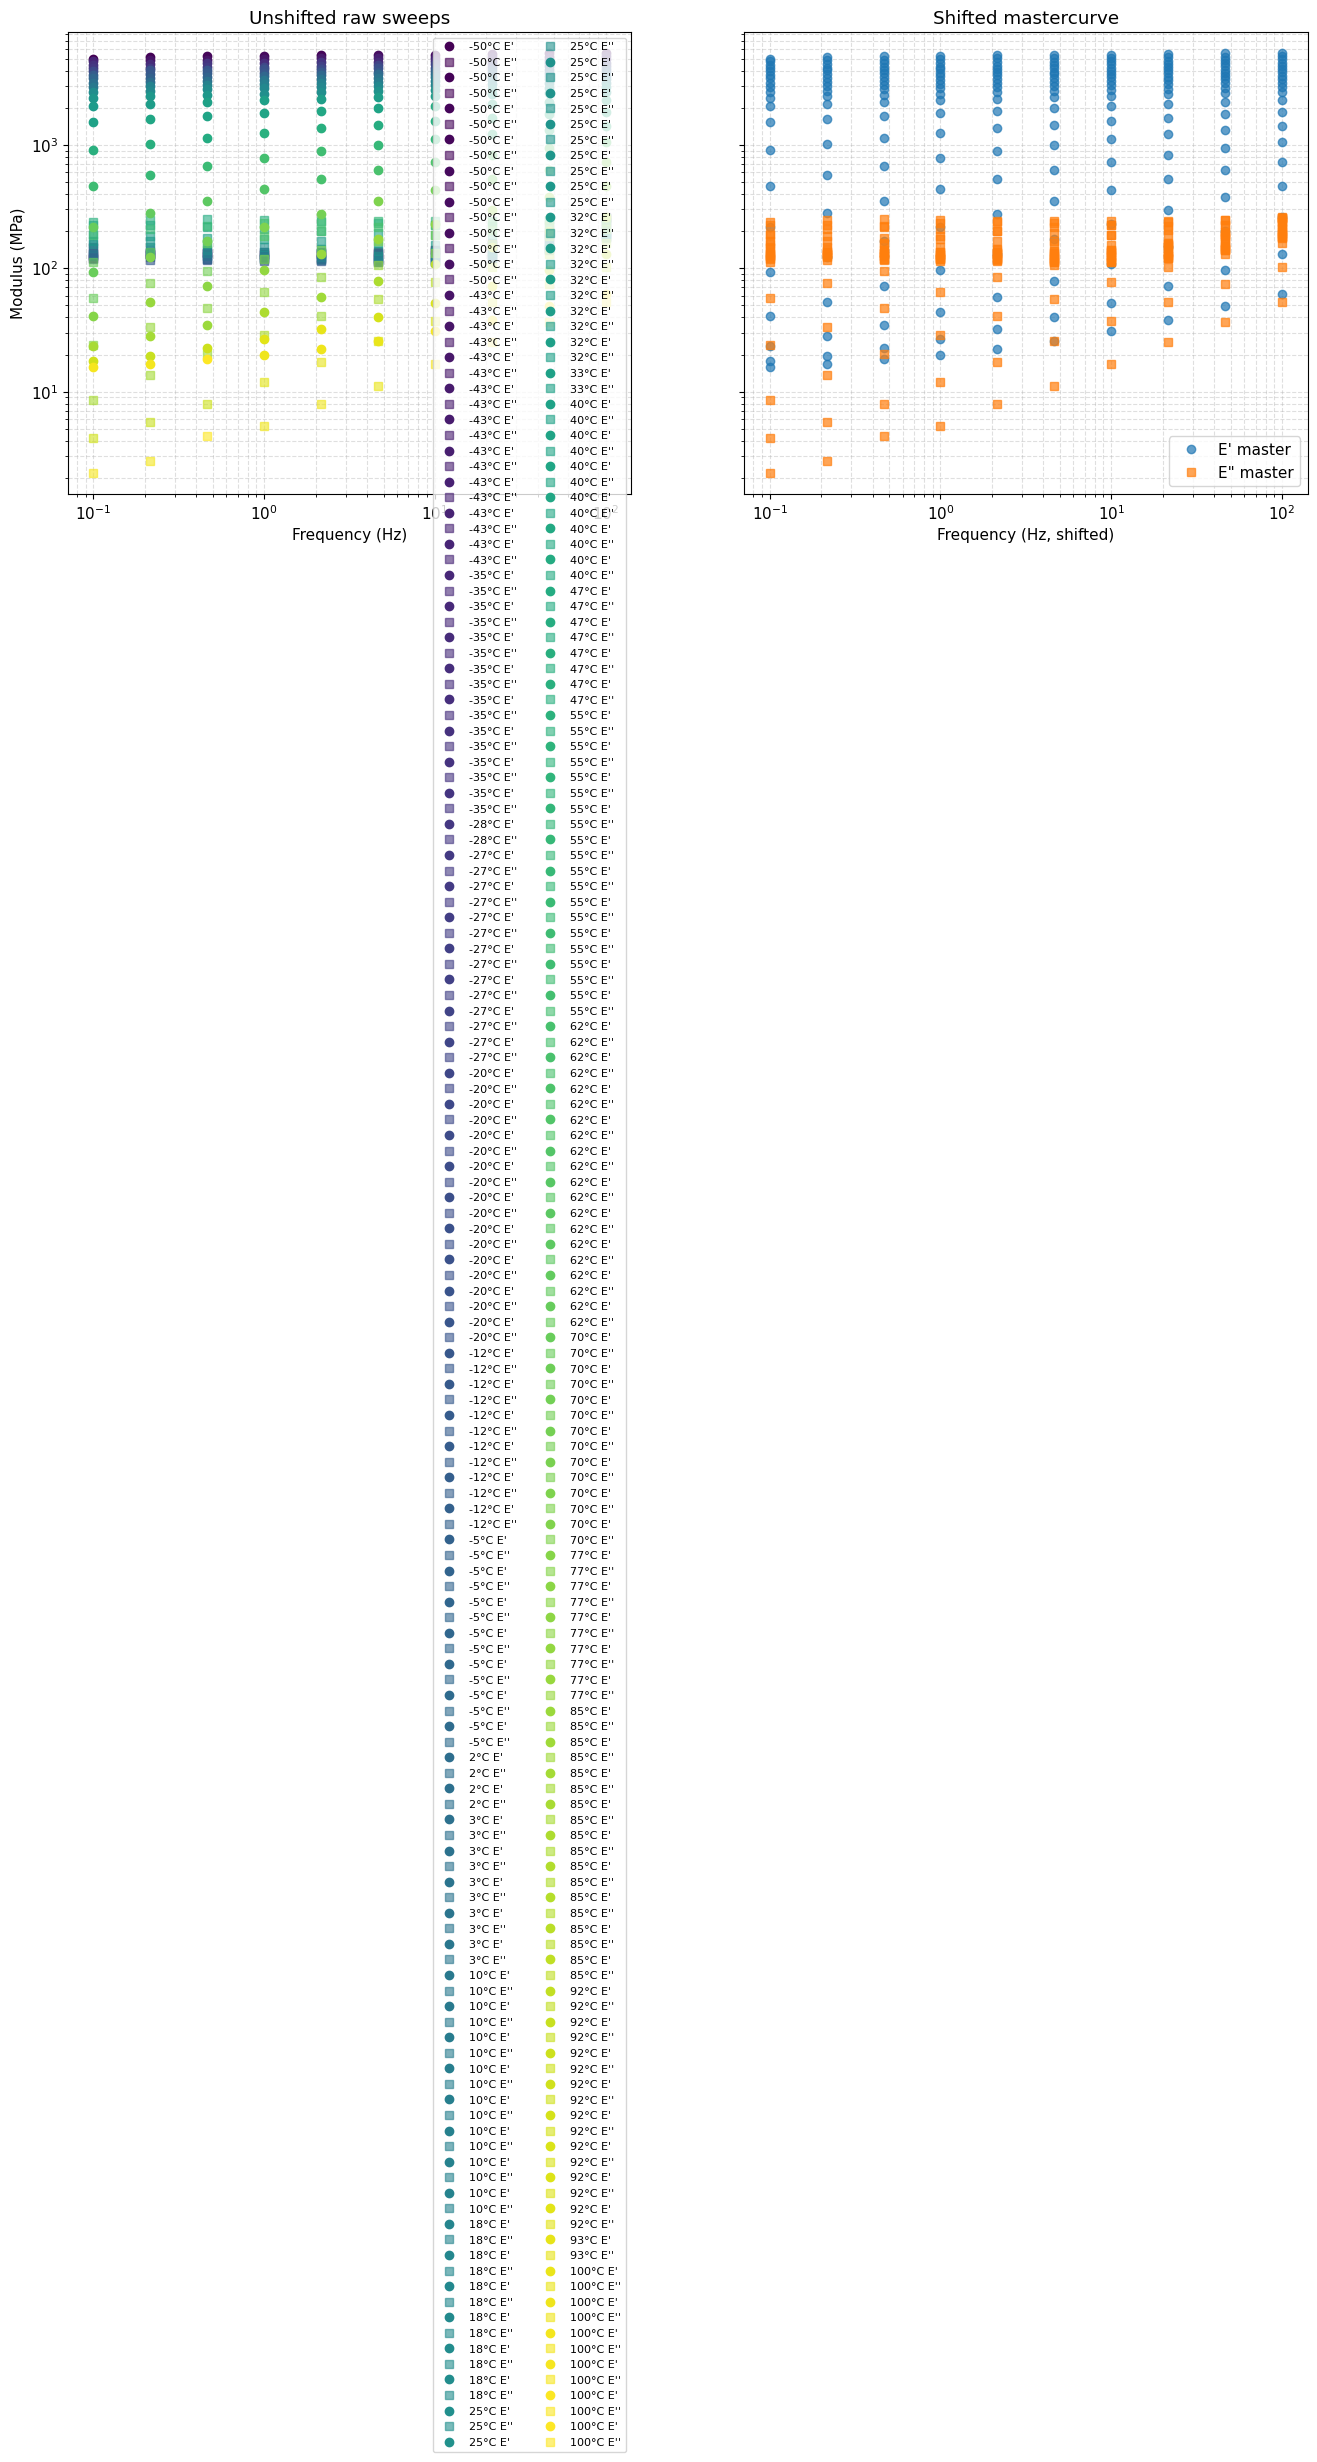

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
colors = plt.cm.viridis(np.linspace(0, 1, len(datasets)))

for color, data in zip(colors, datasets):
    temp_c = data.metadata['temperature'] - 273.15
    axes[0].loglog(data.x / (2*np.pi), np.real(data.y), 'o', color=color, label=f"{temp_c:.0f}°C E'")
    axes[0].loglog(data.x / (2*np.pi), np.imag(data.y), 's', color=color, alpha=0.6, label=f"{temp_c:.0f}°C E''")
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Modulus (MPa)')
axes[0].set_title('Unshifted raw sweeps')
axes[0].grid(True, which='both', ls='--', alpha=0.4)
axes[0].legend(ncol=2, fontsize=8)

axes[1].loglog(master.x / (2*np.pi), np.real(master.y), 'o', label="E' master", alpha=0.7)
axes[1].loglog(master.x / (2*np.pi), np.imag(master.y), 's', label='E" master', alpha=0.7)
axes[1].set_xlabel('Frequency (Hz, shifted)')
axes[1].set_title('Shifted mastercurve')
axes[1].grid(True, which='both', ls='--', alpha=0.4)
axes[1].legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Fit models on mastercurve

In [5]:
omega_master = master.x
G_master = master.y

# Generalized Maxwell on mastercurve
gm = GeneralizedMaxwell(n_modes=6, modulus_type='tensile')
gm.fit(omega_master, G_master, test_mode='oscillation', use_log_residuals=True)
gm_pred_components = gm.predict(omega_master)
gm_pred = gm_pred_components[:, 0] + 1j * gm_pred_components[:, 1]
gm_r2 = r2_complex(G_master, gm_pred)

fm_pred = np.full_like(G_master, np.nan)
fm_r2 = np.nan
try:
    fm = FractionalMaxwellModel()
    fm.fit(omega_master, G_master, test_mode='oscillation', use_log_residuals=True)
    fm_pred = fm.predict(omega_master, test_mode='oscillation')
    fm_r2 = r2_complex(G_master, fm_pred)
except Exception as exc:
    print(f"Fractional Maxwell fit failed: {exc}")

print(f"Generalized Maxwell R^2: {gm_r2:.4f}")
print(f"Fractional Maxwell R^2:   {fm_r2 if np.isfinite(fm_r2) else float('nan'):.4f}")

Starting least squares optimization | {'method': 'trf', 'n_params': 13, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 1.358109s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=20 | final_cost=3.323818e+08 | time=1.358s | final_gradient_norm=15666336330359.125


Starting least squares optimization | {'method': 'trf', 'n_params': 13, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.324167s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=20 | final_cost=3.323818e+08 | time=0.324s | final_gradient_norm=15666336330359.125


Starting least squares optimization | {'method': 'trf', 'n_params': 11, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.973869s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=9 | final_cost=3.323801e+08 | time=0.974s | final_gradient_norm=3115663675597.077


Starting least squares optimization | {'method': 'trf', 'n_params': 9, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.863154s


Convergence: reason=Both `ftol` and `xtol` termination conditions are satisfied. | iterations=4 | final_cost=3.324026e+08 | time=0.863s | final_gradient_norm=691049881990.4137


Starting least squares optimization | {'method': 'trf', 'n_params': 7, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.715015s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=15 | final_cost=3.324352e+08 | time=0.715s | final_gradient_norm=310643.68883575464


Starting least squares optimization | {'method': 'trf', 'n_params': 5, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.648352s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=13 | final_cost=3.326809e+08 | time=0.648s | final_gradient_norm=2177756413559.4878


Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.559827s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=19 | final_cost=3.336443e+08 | time=0.560s | final_gradient_norm=598973382050.7024


Element minimization: reducing from 6 to 1 modes


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.697046s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=22 | final_cost=1.560306e+02 | time=0.697s | final_gradient_norm=76517.33832053197


Generalized Maxwell R^2: 0.0048
Fractional Maxwell R^2:   -1.8297


## Overlay fits on shifted data

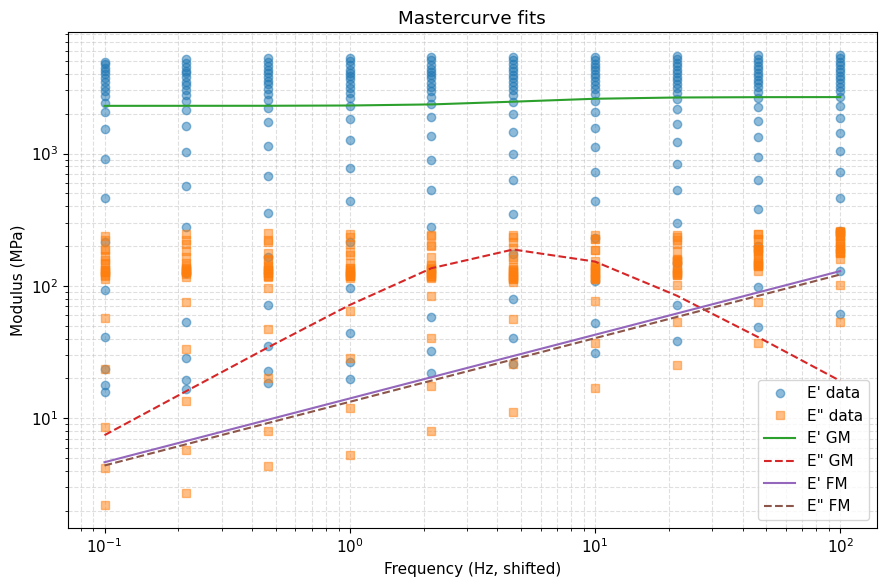

In [6]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.loglog(master.x / (2*np.pi), np.real(master.y), 'o', label="E' data", alpha=0.5)
ax.loglog(master.x / (2*np.pi), np.imag(master.y), 's', label='E" data', alpha=0.5)
ax.loglog(master.x / (2*np.pi), np.real(gm_pred), '-', label="E' GM")
ax.loglog(master.x / (2*np.pi), np.imag(gm_pred), '--', label='E" GM')

if np.isfinite(fm_r2):
    ax.loglog(master.x / (2*np.pi), np.real(fm_pred), '-', label="E' FM")
    ax.loglog(master.x / (2*np.pi), np.imag(fm_pred), '--', label='E" FM')
else:
    ax.text(0.5, 0.1, 'Fractional fit failed', transform=ax.transAxes)

ax.set_xlabel('Frequency (Hz, shifted)')
ax.set_ylabel('Modulus (MPa)')
ax.set_title('Mastercurve fits')
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Skipping gm due to fit error: NLSQ optimization failed with error: `x0` is infeasible.
This may indicate:
  1. Data is unsuitable for GMM fitting (e.g., constant values)
  2. Initial parameter guess is outside bounds
  3. Too many modes for the available data


Timer: optimization took 0.403409s


Convergence: reason=`xtol` termination condition is satisfied. | iterations=1 | final_cost=2.511253e-01 | time=0.403s | final_gradient_norm=2.1460060123909894


Model ranking (R²): [('fm', -inf)]


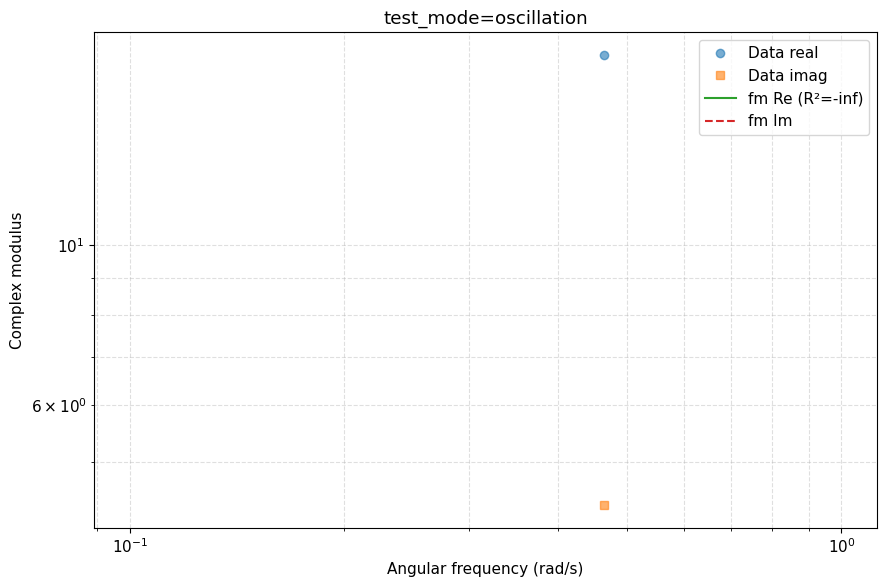

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:00<45:37,  1.46it/s, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:  10%|█         | 403/4000 [00:00<00:05, 694.13it/s, 511 steps of size 2.73e-05. acc. prob=0.77]

warmup:  16%|█▌        | 638/4000 [00:00<00:03, 981.85it/s, 127 steps of size 3.39e-05. acc. prob=0.78]

warmup:  22%|██▏       | 874/4000 [00:01<00:02, 1275.87it/s, 31 steps of size 2.78e-05. acc. prob=0.78]

sample:  28%|██▊       | 1131/4000 [00:01<00:01, 1578.16it/s, 63 steps of size 2.40e-05. acc. prob=0.95]

sample:  35%|███▌      | 1401/4000 [00:01<00:01, 1858.51it/s, 31 steps of size 2.40e-05. acc. prob=0.95]

sample:  42%|████▏     | 1697/4000 [00:01<00:01, 2147.92it/s, 143 steps of size 2.40e-05. acc. prob=0.95]

sample:  49%|████▉     | 1968/4000 [00:01<00:00, 2291.94it/s, 543 steps of size 2.40e-05. acc. prob=0.95]

sample:  56%|█████▌    | 2237/4000 [00:01<00:00, 2402.29it/s, 31 steps of size 2.40e-05. acc. prob=0.95] 

sample:  63%|██████▎   | 2537/4000 [00:01<00:00, 2571.90it/s, 63 steps of size 2.40e-05. acc. prob=0.95]

sample:  71%|███████   | 2843/4000 [00:01<00:00, 2711.80it/s, 31 steps of size 2.40e-05. acc. prob=0.95]

sample:  79%|███████▉  | 3178/4000 [00:01<00:00, 2898.12it/s, 31 steps of size 2.40e-05. acc. prob=0.95]

sample:  87%|████████▋ | 3498/4000 [00:01<00:00, 2984.88it/s, 127 steps of size 2.40e-05. acc. prob=0.95]

sample:  96%|█████████▌| 3836/4000 [00:02<00:00, 3099.61it/s, 31 steps of size 2.40e-05. acc. prob=0.95] 

sample: 100%|██████████| 4000/4000 [00:02<00:00, 1939.09it/s, 31 steps of size 2.40e-05. acc. prob=0.95]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   8%|▊         | 339/4000 [00:00<00:01, 3386.85it/s, 63 steps of size 1.20e-05. acc. prob=0.77]

warmup:  17%|█▋        | 678/4000 [00:00<00:01, 2378.16it/s, 127 steps of size 4.05e-05. acc. prob=0.78]

warmup:  23%|██▎       | 934/4000 [00:00<00:01, 2313.91it/s, 31 steps of size 2.57e-05. acc. prob=0.78] 

sample:  30%|██▉       | 1187/4000 [00:00<00:01, 2385.26it/s, 63 steps of size 2.48e-05. acc. prob=0.94]

sample:  36%|███▌      | 1440/4000 [00:00<00:01, 2431.45it/s, 63 steps of size 2.48e-05. acc. prob=0.95]

sample:  42%|████▏     | 1688/4000 [00:00<00:00, 2399.57it/s, 15 steps of size 2.48e-05. acc. prob=0.95]

sample:  48%|████▊     | 1933/4000 [00:00<00:00, 2414.15it/s, 31 steps of size 2.48e-05. acc. prob=0.95]

sample:  56%|█████▌    | 2241/4000 [00:00<00:00, 2615.98it/s, 31 steps of size 2.48e-05. acc. prob=0.94]

sample:  63%|██████▎   | 2524/4000 [00:00<00:00, 2671.41it/s, 639 steps of size 2.48e-05. acc. prob=0.94]

sample:  71%|███████   | 2835/4000 [00:01<00:00, 2801.50it/s, 63 steps of size 2.48e-05. acc. prob=0.95] 

sample:  79%|███████▊  | 3143/4000 [00:01<00:00, 2884.14it/s, 31 steps of size 2.48e-05. acc. prob=0.94]

sample:  86%|████████▋ | 3458/4000 [00:01<00:00, 2961.94it/s, 31 steps of size 2.48e-05. acc. prob=0.94]

sample:  94%|█████████▍| 3780/4000 [00:01<00:00, 3019.66it/s, 1023 steps of size 2.48e-05. acc. prob=0.94]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2720.71it/s, 31 steps of size 2.48e-05. acc. prob=0.94]  

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:  10%|█         | 414/4000 [00:00<00:00, 4108.00it/s, 511 steps of size 2.20e-05. acc. prob=0.77]

warmup:  21%|██        | 825/4000 [00:00<00:01, 2386.70it/s, 63 steps of size 2.81e-05. acc. prob=0.78] 

sample:  28%|██▊       | 1103/4000 [00:00<00:01, 2405.17it/s, 15 steps of size 2.42e-05. acc. prob=0.93]

sample:  34%|███▍      | 1366/4000 [00:00<00:01, 2443.45it/s, 63 steps of size 2.42e-05. acc. prob=0.93]

sample:  41%|████      | 1628/4000 [00:00<00:00, 2496.69it/s, 127 steps of size 2.42e-05. acc. prob=0.93]

sample:  48%|████▊     | 1905/4000 [00:00<00:00, 2574.08it/s, 511 steps of size 2.42e-05. acc. prob=0.94]

sample:  55%|█████▍    | 2195/4000 [00:00<00:00, 2670.45it/s, 31 steps of size 2.42e-05. acc. prob=0.94] 

sample:  62%|██████▏   | 2474/4000 [00:00<00:00, 2705.06it/s, 63 steps of size 2.42e-05. acc. prob=0.94]

sample:  69%|██████▊   | 2749/4000 [00:01<00:00, 2609.57it/s, 31 steps of size 2.42e-05. acc. prob=0.94]

sample:  76%|███████▌  | 3036/4000 [00:01<00:00, 2684.54it/s, 31 steps of size 2.42e-05. acc. prob=0.93]

sample:  84%|████████▎ | 3345/4000 [00:01<00:00, 2803.23it/s, 63 steps of size 2.42e-05. acc. prob=0.93]

sample:  91%|█████████ | 3628/4000 [00:01<00:00, 2791.89it/s, 31 steps of size 2.42e-05. acc. prob=0.93]

sample:  98%|█████████▊| 3923/4000 [00:01<00:00, 2836.65it/s, 63 steps of size 2.42e-05. acc. prob=0.93]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2694.84it/s, 31 steps of size 2.42e-05. acc. prob=0.93]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:  10%|▉         | 397/4000 [00:00<00:00, 3954.50it/s, 63 steps of size 3.28e-05. acc. prob=0.77]

warmup:  20%|█▉        | 793/4000 [00:00<00:01, 2737.69it/s, 5 steps of size 2.63e-05. acc. prob=0.78] 

sample:  27%|██▋       | 1089/4000 [00:00<00:01, 2676.14it/s, 143 steps of size 1.94e-05. acc. prob=0.95]

sample:  34%|███▍      | 1368/4000 [00:00<00:00, 2647.82it/s, 63 steps of size 1.94e-05. acc. prob=0.94] 

sample:  41%|████      | 1639/4000 [00:00<00:00, 2628.38it/s, 63 steps of size 1.94e-05. acc. prob=0.94]

sample:  48%|████▊     | 1906/4000 [00:00<00:00, 2598.87it/s, 63 steps of size 1.94e-05. acc. prob=0.94]

sample:  55%|█████▍    | 2182/4000 [00:00<00:00, 2645.98it/s, 31 steps of size 1.94e-05. acc. prob=0.94]

sample:  61%|██████    | 2449/4000 [00:00<00:00, 2579.78it/s, 15 steps of size 1.94e-05. acc. prob=0.94]

sample:  68%|██████▊   | 2728/4000 [00:01<00:00, 2638.60it/s, 511 steps of size 1.94e-05. acc. prob=0.94]

sample:  76%|███████▌  | 3022/4000 [00:01<00:00, 2726.32it/s, 63 steps of size 1.94e-05. acc. prob=0.94] 

sample:  83%|████████▎ | 3302/4000 [00:01<00:00, 2747.66it/s, 15 steps of size 1.94e-05. acc. prob=0.94]

sample:  90%|█████████ | 3606/4000 [00:01<00:00, 2834.69it/s, 63 steps of size 1.94e-05. acc. prob=0.94]

sample:  98%|█████████▊| 3905/4000 [00:01<00:00, 2879.23it/s, 63 steps of size 1.94e-05. acc. prob=0.94]

sample: 100%|██████████| 4000/4000 [00:01<00:00, 2761.58it/s, 287 steps of size 1.94e-05. acc. prob=0.94]

array([[<Axes: ylabel='beta'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='c1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma_imag'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='sigma_real'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: xlabel='alpha', ylabel='tau'>, <Axes: xlabel='beta'>,
        <Axes: xlabel='c1'>, <Axes: xlabel='sigma_imag'>,
        <Axes: xlabel='sigma_real'>]], dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'alpha\n0'}>,
        <Axes: title={'center': 'alpha\n1'}>,
        <Axes: title={'center': 'alpha\n2'}>,
        <Axes: title={'center': 'alpha\n3'}>],
       [<Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n2'}>,
        <Axes: title={'center': 'beta\n3'}>],
       [<Axes: title={'center': 'c1\n0'}>,
        <Axes: title={'center': 'c1\n1'}>,
        <Axes: title={'center': 'c1\n2'}>,
        <Axes: title={'center': 'c1\n3'}>],
       [<Axes: title={'center': 'sigma_imag\n0'}>,
        <Axes: title={'center': 'sigma_imag\n1'}>,
        <Axes: title={'center': 'sigma_imag\n2'}>,
        <Axes: title={'center': 'sigma_imag\n3'}>],
       [<Axes: title={'center': 'sigma_real\n0'}>,
        <Axes: title={'center': 'sigma_real\n1'}>,
        <Axes: title={'center': 'sigma_real\n2'}>,
        <Axes: title={'center': 'sigma_real\n3'}>],
       [<Axes: title={'center': 'tau\n0'}>,
       

array([[<Axes: title={'center': 'alpha'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'c1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

array([[<Axes: title={'center': 'alpha'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'beta'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'c1'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'sigma_imag'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma_real'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau'}, xlabel='Total number of draws', ylabel='ESS'>]],
      dtype=object)

Starting least squares optimization | {'method': 'trf', 'n_params': 3, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.203172s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=22 | final_cost=3.336443e+08 | time=0.203s | final_gradient_norm=590378805156.1083


Starting least squares optimization | {'method': 'trf', 'n_params': 4, 'loss': 'linear', 'ftol': 1e-06, 'xtol': 1e-06, 'gtol': 1e-06}


Timer: optimization took 0.265144s


Convergence: reason=`ftol` termination condition is satisfied. | iterations=22 | final_cost=1.560306e+02 | time=0.265s | final_gradient_norm=76517.33832053197


Model ranking (R²): [('gm', 0.005), ('fm', -1.83)]


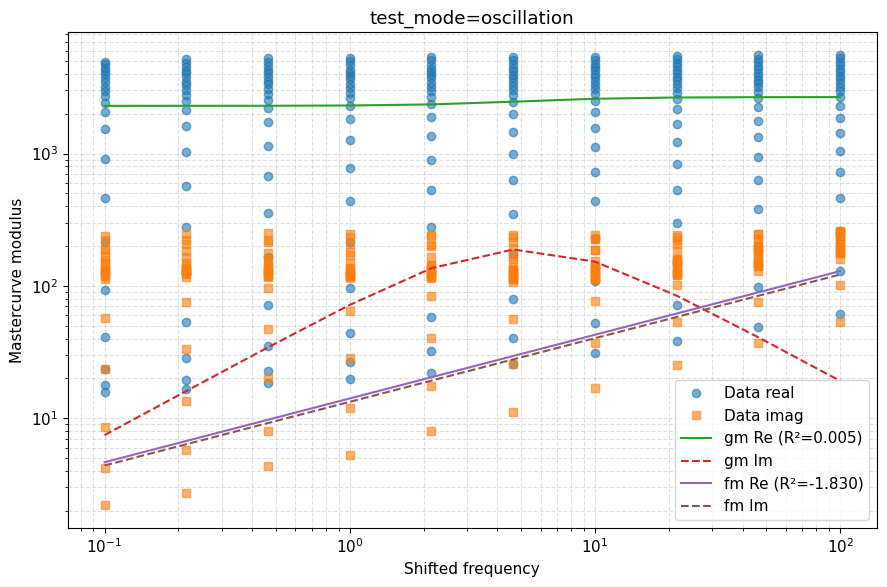

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   0%|          | 1/4000 [00:00<40:00,  1.67it/s, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:   4%|▎         | 142/4000 [00:00<00:14, 272.21it/s, 31 steps of size 1.16e-01. acc. prob=0.77]

warmup:   6%|▌         | 225/4000 [00:00<00:10, 358.33it/s, 255 steps of size 2.38e-02. acc. prob=0.78]

warmup:   7%|▋         | 297/4000 [00:00<00:09, 403.36it/s, 127 steps of size 4.62e-02. acc. prob=0.78]

warmup:   9%|▉         | 378/4000 [00:01<00:07, 493.88it/s, 127 steps of size 3.33e-02. acc. prob=0.78]

warmup:  11%|█▏        | 458/4000 [00:01<00:06, 565.34it/s, 511 steps of size 1.16e-02. acc. prob=0.78]

warmup:  13%|█▎        | 531/4000 [00:01<00:05, 584.84it/s, 63 steps of size 1.42e-02. acc. prob=0.78] 

warmup:  15%|█▌        | 614/4000 [00:01<00:05, 646.69it/s, 127 steps of size 4.28e-02. acc. prob=0.79]

warmup:  18%|█▊        | 700/4000 [00:01<00:04, 702.99it/s, 63 steps of size 4.04e-02. acc. prob=0.79] 

warmup:  20%|█▉        | 784/4000 [00:01<00:04, 739.19it/s, 127 steps of size 4.11e-02. acc. prob=0.79]

warmup:  22%|██▏       | 869/4000 [00:01<00:04, 769.11it/s, 63 steps of size 4.17e-02. acc. prob=0.79] 

warmup:  24%|██▍       | 957/4000 [00:01<00:03, 798.79it/s, 63 steps of size 6.86e-02. acc. prob=0.79]

sample:  26%|██▌       | 1040/4000 [00:01<00:04, 731.97it/s, 127 steps of size 3.41e-02. acc. prob=0.97]

sample:  28%|██▊       | 1118/4000 [00:02<00:03, 742.13it/s, 127 steps of size 3.41e-02. acc. prob=0.95]

sample:  30%|██▉       | 1195/4000 [00:02<00:03, 713.66it/s, 127 steps of size 3.41e-02. acc. prob=0.95]

sample:  32%|███▏      | 1269/4000 [00:02<00:03, 716.26it/s, 63 steps of size 3.41e-02. acc. prob=0.95] 

sample:  34%|███▎      | 1344/4000 [00:02<00:03, 723.69it/s, 95 steps of size 3.41e-02. acc. prob=0.95]

sample:  35%|███▌      | 1418/4000 [00:02<00:03, 703.56it/s, 127 steps of size 3.41e-02. acc. prob=0.95]

sample:  37%|███▋      | 1490/4000 [00:02<00:03, 707.16it/s, 63 steps of size 3.41e-02. acc. prob=0.95] 

sample:  39%|███▉      | 1562/4000 [00:02<00:03, 707.73it/s, 63 steps of size 3.41e-02. acc. prob=0.95]

sample:  41%|████      | 1634/4000 [00:02<00:03, 693.92it/s, 127 steps of size 3.41e-02. acc. prob=0.95]

sample:  43%|████▎     | 1704/4000 [00:02<00:03, 689.46it/s, 63 steps of size 3.41e-02. acc. prob=0.95] 

sample:  44%|████▍     | 1775/4000 [00:02<00:03, 694.41it/s, 127 steps of size 3.41e-02. acc. prob=0.95]

sample:  46%|████▌     | 1849/4000 [00:03<00:03, 705.48it/s, 127 steps of size 3.41e-02. acc. prob=0.95]

sample:  48%|████▊     | 1921/4000 [00:03<00:02, 708.16it/s, 255 steps of size 3.41e-02. acc. prob=0.95]

sample:  50%|████▉     | 1998/4000 [00:03<00:02, 724.68it/s, 127 steps of size 3.41e-02. acc. prob=0.95]

sample:  52%|█████▏    | 2071/4000 [00:03<00:02, 722.32it/s, 63 steps of size 3.41e-02. acc. prob=0.95] 

sample:  54%|█████▎    | 2144/4000 [00:03<00:02, 722.83it/s, 63 steps of size 3.41e-02. acc. prob=0.95]

sample:  55%|█████▌    | 2218/4000 [00:03<00:02, 727.08it/s, 127 steps of size 3.41e-02. acc. prob=0.95]

sample:  57%|█████▋    | 2291/4000 [00:03<00:02, 718.57it/s, 63 steps of size 3.41e-02. acc. prob=0.95] 

sample:  59%|█████▉    | 2363/4000 [00:03<00:02, 709.44it/s, 127 steps of size 3.41e-02. acc. prob=0.95]

sample:  61%|██████    | 2434/4000 [00:03<00:02, 684.24it/s, 63 steps of size 3.41e-02. acc. prob=0.95] 

sample:  63%|██████▎   | 2507/4000 [00:04<00:02, 693.74it/s, 127 steps of size 3.41e-02. acc. prob=0.95]

sample:  64%|██████▍   | 2577/4000 [00:04<00:02, 683.15it/s, 127 steps of size 3.41e-02. acc. prob=0.95]

sample:  66%|██████▌   | 2646/4000 [00:04<00:01, 677.20it/s, 127 steps of size 3.41e-02. acc. prob=0.95]

sample:  68%|██████▊   | 2714/4000 [00:04<00:01, 671.10it/s, 127 steps of size 3.41e-02. acc. prob=0.95]

sample:  70%|██████▉   | 2785/4000 [00:04<00:01, 681.37it/s, 63 steps of size 3.41e-02. acc. prob=0.95] 

sample:  71%|███████▏  | 2854/4000 [00:04<00:01, 675.74it/s, 63 steps of size 3.41e-02. acc. prob=0.95]

sample:  73%|███████▎  | 2922/4000 [00:04<00:01, 670.46it/s, 63 steps of size 3.41e-02. acc. prob=0.95]

sample:  75%|███████▍  | 2990/4000 [00:04<00:01, 664.47it/s, 15 steps of size 3.41e-02. acc. prob=0.95]

sample:  77%|███████▋  | 3062/4000 [00:04<00:01, 680.67it/s, 127 steps of size 3.41e-02. acc. prob=0.95]

sample:  78%|███████▊  | 3131/4000 [00:04<00:01, 671.48it/s, 63 steps of size 3.41e-02. acc. prob=0.95] 

sample:  80%|████████  | 3200/4000 [00:05<00:01, 674.01it/s, 159 steps of size 3.41e-02. acc. prob=0.95]

sample:  82%|████████▏ | 3272/4000 [00:05<00:01, 686.58it/s, 127 steps of size 3.41e-02. acc. prob=0.95]

sample:  84%|████████▎ | 3346/4000 [00:05<00:00, 699.96it/s, 127 steps of size 3.41e-02. acc. prob=0.95]

sample:  85%|████████▌ | 3417/4000 [00:05<00:00, 701.75it/s, 127 steps of size 3.41e-02. acc. prob=0.95]

sample:  87%|████████▋ | 3488/4000 [00:05<00:00, 697.78it/s, 31 steps of size 3.41e-02. acc. prob=0.95] 

sample:  89%|████████▉ | 3558/4000 [00:05<00:00, 696.47it/s, 63 steps of size 3.41e-02. acc. prob=0.95]

sample:  91%|█████████ | 3628/4000 [00:05<00:00, 693.72it/s, 127 steps of size 3.41e-02. acc. prob=0.95]

sample:  93%|█████████▎| 3701/4000 [00:05<00:00, 704.26it/s, 127 steps of size 3.41e-02. acc. prob=0.95]

sample:  94%|█████████▍| 3772/4000 [00:05<00:00, 684.51it/s, 127 steps of size 3.41e-02. acc. prob=0.95]

sample:  96%|█████████▌| 3841/4000 [00:05<00:00, 668.96it/s, 127 steps of size 3.41e-02. acc. prob=0.95]

sample:  98%|█████████▊| 3924/4000 [00:06<00:00, 712.39it/s, 111 steps of size 3.41e-02. acc. prob=0.95]

sample: 100%|█████████▉| 3996/4000 [00:06<00:00, 697.22it/s, 127 steps of size 3.41e-02. acc. prob=0.95]

sample: 100%|██████████| 4000/4000 [00:06<00:00, 645.47it/s, 23 steps of size 3.41e-02. acc. prob=0.95] 

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   3%|▎         | 119/4000 [00:00<00:03, 1180.50it/s, 127 steps of size 7.78e-02. acc. prob=0.77]

warmup:   6%|▌         | 238/4000 [00:00<00:05, 743.84it/s, 63 steps of size 5.17e-02. acc. prob=0.78]  

warmup:   8%|▊         | 322/4000 [00:00<00:05, 705.25it/s, 255 steps of size 2.96e-02. acc. prob=0.78]

warmup:  10%|█         | 401/4000 [00:00<00:04, 728.84it/s, 127 steps of size 6.68e-02. acc. prob=0.78]

warmup:  12%|█▏        | 478/4000 [00:00<00:04, 730.71it/s, 63 steps of size 6.04e-02. acc. prob=0.78] 

warmup:  14%|█▍        | 557/4000 [00:00<00:04, 748.52it/s, 127 steps of size 3.12e-02. acc. prob=0.79]

warmup:  16%|█▌        | 645/4000 [00:00<00:04, 786.25it/s, 63 steps of size 7.99e-02. acc. prob=0.79] 

warmup:  18%|█▊        | 737/4000 [00:00<00:03, 825.79it/s, 63 steps of size 5.03e-02. acc. prob=0.79]

warmup:  21%|██        | 827/4000 [00:01<00:03, 846.36it/s, 63 steps of size 4.60e-02. acc. prob=0.79]

warmup:  23%|██▎       | 930/4000 [00:01<00:03, 899.24it/s, 63 steps of size 4.31e-02. acc. prob=0.79]

sample:  26%|██▌       | 1021/4000 [00:01<00:03, 812.69it/s, 127 steps of size 3.44e-02. acc. prob=0.95]

sample:  28%|██▊       | 1105/4000 [00:01<00:03, 789.58it/s, 87 steps of size 3.44e-02. acc. prob=0.95] 

sample:  30%|██▉       | 1186/4000 [00:01<00:03, 757.02it/s, 63 steps of size 3.44e-02. acc. prob=0.95]

sample:  32%|███▏      | 1263/4000 [00:01<00:03, 729.56it/s, 63 steps of size 3.44e-02. acc. prob=0.95]

sample:  34%|███▎      | 1341/4000 [00:01<00:03, 742.39it/s, 127 steps of size 3.44e-02. acc. prob=0.95]

sample:  35%|███▌      | 1416/4000 [00:01<00:03, 724.36it/s, 127 steps of size 3.44e-02. acc. prob=0.95]

sample:  37%|███▋      | 1489/4000 [00:01<00:03, 713.83it/s, 63 steps of size 3.44e-02. acc. prob=0.95] 

sample:  39%|███▉      | 1561/4000 [00:02<00:03, 705.47it/s, 27 steps of size 3.44e-02. acc. prob=0.95]

sample:  41%|████      | 1632/4000 [00:02<00:03, 706.13it/s, 127 steps of size 3.44e-02. acc. prob=0.95]

sample:  43%|████▎     | 1708/4000 [00:02<00:03, 719.79it/s, 127 steps of size 3.44e-02. acc. prob=0.95]

sample:  45%|████▍     | 1784/4000 [00:02<00:03, 730.50it/s, 63 steps of size 3.44e-02. acc. prob=0.95] 

sample:  46%|████▋     | 1858/4000 [00:02<00:02, 723.08it/s, 127 steps of size 3.44e-02. acc. prob=0.95]

sample:  48%|████▊     | 1934/4000 [00:02<00:02, 731.85it/s, 127 steps of size 3.44e-02. acc. prob=0.95]

sample:  50%|█████     | 2008/4000 [00:02<00:02, 733.08it/s, 127 steps of size 3.44e-02. acc. prob=0.95]

sample:  52%|█████▏    | 2082/4000 [00:02<00:02, 721.64it/s, 127 steps of size 3.44e-02. acc. prob=0.95]

sample:  54%|█████▍    | 2155/4000 [00:02<00:02, 706.02it/s, 31 steps of size 3.44e-02. acc. prob=0.95] 

sample:  56%|█████▌    | 2226/4000 [00:02<00:02, 691.55it/s, 127 steps of size 3.44e-02. acc. prob=0.95]

sample:  57%|█████▋    | 2296/4000 [00:03<00:02, 686.58it/s, 127 steps of size 3.44e-02. acc. prob=0.95]

sample:  59%|█████▉    | 2376/4000 [00:03<00:02, 715.42it/s, 127 steps of size 3.44e-02. acc. prob=0.95]

sample:  61%|██████▏   | 2451/4000 [00:03<00:02, 723.90it/s, 63 steps of size 3.44e-02. acc. prob=0.95] 

sample:  63%|██████▎   | 2524/4000 [00:03<00:02, 717.83it/s, 127 steps of size 3.44e-02. acc. prob=0.95]

sample:  65%|██████▍   | 2596/4000 [00:03<00:02, 701.67it/s, 127 steps of size 3.44e-02. acc. prob=0.95]

sample:  67%|██████▋   | 2667/4000 [00:03<00:01, 702.65it/s, 63 steps of size 3.44e-02. acc. prob=0.95] 

sample:  68%|██████▊   | 2740/4000 [00:03<00:01, 709.29it/s, 127 steps of size 3.44e-02. acc. prob=0.95]

sample:  70%|███████   | 2811/4000 [00:03<00:01, 704.99it/s, 127 steps of size 3.44e-02. acc. prob=0.95]

sample:  72%|███████▏  | 2882/4000 [00:03<00:01, 688.70it/s, 63 steps of size 3.44e-02. acc. prob=0.95] 

sample:  74%|███████▍  | 2955/4000 [00:04<00:01, 698.30it/s, 127 steps of size 3.44e-02. acc. prob=0.95]

sample:  76%|███████▌  | 3025/4000 [00:04<00:01, 693.05it/s, 87 steps of size 3.44e-02. acc. prob=0.95] 

sample:  77%|███████▋  | 3097/4000 [00:04<00:01, 697.30it/s, 127 steps of size 3.44e-02. acc. prob=0.95]

sample:  79%|███████▉  | 3171/4000 [00:04<00:01, 708.88it/s, 127 steps of size 3.44e-02. acc. prob=0.95]

sample:  81%|████████  | 3244/4000 [00:04<00:01, 714.42it/s, 127 steps of size 3.44e-02. acc. prob=0.95]

sample:  83%|████████▎ | 3316/4000 [00:04<00:00, 690.97it/s, 63 steps of size 3.44e-02. acc. prob=0.95] 

sample:  85%|████████▍ | 3386/4000 [00:04<00:00, 677.23it/s, 127 steps of size 3.44e-02. acc. prob=0.95]

sample:  87%|████████▋ | 3462/4000 [00:04<00:00, 700.52it/s, 63 steps of size 3.44e-02. acc. prob=0.95] 

sample:  88%|████████▊ | 3533/4000 [00:04<00:00, 701.38it/s, 63 steps of size 3.44e-02. acc. prob=0.95]

sample:  90%|█████████ | 3604/4000 [00:04<00:00, 699.77it/s, 63 steps of size 3.44e-02. acc. prob=0.95]

sample:  92%|█████████▏| 3678/4000 [00:05<00:00, 711.44it/s, 31 steps of size 3.44e-02. acc. prob=0.95]

sample:  94%|█████████▍| 3750/4000 [00:05<00:00, 707.58it/s, 127 steps of size 3.44e-02. acc. prob=0.95]

sample:  96%|█████████▌| 3821/4000 [00:05<00:00, 700.60it/s, 31 steps of size 3.44e-02. acc. prob=0.95] 

sample:  97%|█████████▋| 3896/4000 [00:05<00:00, 711.18it/s, 127 steps of size 3.44e-02. acc. prob=0.95]

sample:  99%|█████████▉| 3968/4000 [00:05<00:00, 710.99it/s, 127 steps of size 3.44e-02. acc. prob=0.95]

sample: 100%|██████████| 4000/4000 [00:05<00:00, 728.38it/s, 63 steps of size 3.44e-02. acc. prob=0.95] 

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   4%|▍         | 161/4000 [00:00<00:02, 1516.41it/s, 383 steps of size 3.68e-02. acc. prob=0.77]

warmup:   9%|▉         | 374/4000 [00:00<00:01, 1865.92it/s, 15 steps of size 2.46e-01. acc. prob=0.78] 

warmup:  14%|█▍        | 562/4000 [00:00<00:02, 1621.44it/s, 15 steps of size 4.33e-02. acc. prob=0.78]

warmup:  18%|█▊        | 728/4000 [00:00<00:03, 993.91it/s, 79 steps of size 3.94e-02. acc. prob=0.79] 

warmup:  21%|██▏       | 852/4000 [00:00<00:03, 875.10it/s, 95 steps of size 9.37e-02. acc. prob=0.79]

warmup:  24%|██▍       | 956/4000 [00:00<00:04, 760.30it/s, 7 steps of size 5.53e-03. acc. prob=0.79] 

sample:  26%|██▌       | 1043/4000 [00:01<00:03, 746.83it/s, 127 steps of size 2.97e-02. acc. prob=0.93]

sample:  28%|██▊       | 1125/4000 [00:01<00:03, 743.93it/s, 63 steps of size 2.97e-02. acc. prob=0.95] 

sample:  30%|███       | 1204/4000 [00:01<00:03, 737.91it/s, 127 steps of size 2.97e-02. acc. prob=0.94]

sample:  32%|███▏      | 1284/4000 [00:01<00:03, 750.30it/s, 127 steps of size 2.97e-02. acc. prob=0.95]

sample:  34%|███▍      | 1363/4000 [00:01<00:03, 758.93it/s, 127 steps of size 2.97e-02. acc. prob=0.95]

sample:  36%|███▌      | 1441/4000 [00:01<00:03, 744.63it/s, 127 steps of size 2.97e-02. acc. prob=0.95]

sample:  38%|███▊      | 1522/4000 [00:01<00:03, 760.76it/s, 127 steps of size 2.97e-02. acc. prob=0.95]

sample:  40%|████      | 1600/4000 [00:01<00:03, 761.85it/s, 127 steps of size 2.97e-02. acc. prob=0.95]

sample:  42%|████▏     | 1680/4000 [00:01<00:03, 769.42it/s, 127 steps of size 2.97e-02. acc. prob=0.95]

sample:  44%|████▍     | 1758/4000 [00:02<00:02, 768.21it/s, 127 steps of size 2.97e-02. acc. prob=0.94]

sample:  46%|████▌     | 1838/4000 [00:02<00:02, 777.30it/s, 127 steps of size 2.97e-02. acc. prob=0.95]

sample:  48%|████▊     | 1917/4000 [00:02<00:02, 765.84it/s, 127 steps of size 2.97e-02. acc. prob=0.95]

sample:  50%|████▉     | 1998/4000 [00:02<00:02, 775.60it/s, 127 steps of size 2.97e-02. acc. prob=0.94]

sample:  52%|█████▏    | 2076/4000 [00:02<00:02, 770.83it/s, 63 steps of size 2.97e-02. acc. prob=0.94] 

sample:  54%|█████▍    | 2154/4000 [00:02<00:02, 766.87it/s, 99 steps of size 2.97e-02. acc. prob=0.95]

sample:  56%|█████▌    | 2233/4000 [00:02<00:02, 773.38it/s, 47 steps of size 2.97e-02. acc. prob=0.95]

sample:  58%|█████▊    | 2319/4000 [00:02<00:02, 798.95it/s, 127 steps of size 2.97e-02. acc. prob=0.94]

sample:  60%|██████    | 2401/4000 [00:02<00:01, 804.99it/s, 127 steps of size 2.97e-02. acc. prob=0.94]

sample:  62%|██████▏   | 2482/4000 [00:02<00:01, 779.56it/s, 27 steps of size 2.97e-02. acc. prob=0.94] 

sample:  64%|██████▍   | 2561/4000 [00:03<00:01, 774.65it/s, 71 steps of size 2.97e-02. acc. prob=0.95]

sample:  66%|██████▌   | 2639/4000 [00:03<00:01, 752.41it/s, 127 steps of size 2.97e-02. acc. prob=0.95]

sample:  68%|██████▊   | 2715/4000 [00:03<00:01, 747.33it/s, 127 steps of size 2.97e-02. acc. prob=0.95]

sample:  70%|██████▉   | 2794/4000 [00:03<00:01, 757.89it/s, 127 steps of size 2.97e-02. acc. prob=0.95]

sample:  72%|███████▏  | 2872/4000 [00:03<00:01, 763.99it/s, 127 steps of size 2.97e-02. acc. prob=0.95]

sample:  74%|███████▍  | 2953/4000 [00:03<00:01, 776.27it/s, 127 steps of size 2.97e-02. acc. prob=0.95]

sample:  76%|███████▌  | 3031/4000 [00:03<00:01, 766.74it/s, 63 steps of size 2.97e-02. acc. prob=0.95] 

sample:  78%|███████▊  | 3112/4000 [00:03<00:01, 779.36it/s, 127 steps of size 2.97e-02. acc. prob=0.95]

sample:  80%|███████▉  | 3196/4000 [00:03<00:01, 796.02it/s, 63 steps of size 2.97e-02. acc. prob=0.95] 

sample:  82%|████████▏ | 3280/4000 [00:04<00:00, 807.96it/s, 47 steps of size 2.97e-02. acc. prob=0.95]

sample:  84%|████████▍ | 3361/4000 [00:04<00:00, 787.10it/s, 47 steps of size 2.97e-02. acc. prob=0.95]

sample:  86%|████████▌ | 3440/4000 [00:04<00:00, 785.34it/s, 127 steps of size 2.97e-02. acc. prob=0.95]

sample:  88%|████████▊ | 3530/4000 [00:04<00:00, 816.46it/s, 127 steps of size 2.97e-02. acc. prob=0.95]

sample:  90%|█████████ | 3620/4000 [00:04<00:00, 840.94it/s, 159 steps of size 2.97e-02. acc. prob=0.95]

sample:  93%|█████████▎| 3705/4000 [00:04<00:00, 823.78it/s, 127 steps of size 2.97e-02. acc. prob=0.95]

sample:  95%|█████████▍| 3789/4000 [00:04<00:00, 828.00it/s, 111 steps of size 2.97e-02. acc. prob=0.95]

sample:  97%|█████████▋| 3872/4000 [00:04<00:00, 811.79it/s, 127 steps of size 2.97e-02. acc. prob=0.95]

sample:  99%|█████████▉| 3954/4000 [00:04<00:00, 788.02it/s, 127 steps of size 2.97e-02. acc. prob=0.95]

sample: 100%|██████████| 4000/4000 [00:04<00:00, 814.47it/s, 127 steps of size 2.97e-02. acc. prob=0.95]

  0%|          | 0/4000 [00:00<?, ?it/s]

warmup:   3%|▎         | 124/4000 [00:00<00:03, 1188.96it/s, 767 steps of size 1.47e-02. acc. prob=0.77]

warmup:   6%|▌         | 243/4000 [00:00<00:05, 751.31it/s, 127 steps of size 4.43e-02. acc. prob=0.78] 

warmup:   8%|▊         | 327/4000 [00:00<00:05, 725.10it/s, 11 steps of size 2.71e-02. acc. prob=0.78] 

warmup:  10%|█         | 411/4000 [00:00<00:04, 760.82it/s, 127 steps of size 3.88e-02. acc. prob=0.78]

warmup:  12%|█▏        | 491/4000 [00:00<00:05, 690.07it/s, 63 steps of size 5.39e-02. acc. prob=0.78] 

warmup:  14%|█▍        | 563/4000 [00:00<00:04, 689.33it/s, 127 steps of size 3.74e-02. acc. prob=0.79]

warmup:  16%|█▌        | 648/4000 [00:00<00:04, 733.90it/s, 159 steps of size 3.03e-02. acc. prob=0.79]

warmup:  18%|█▊        | 737/4000 [00:00<00:04, 778.14it/s, 63 steps of size 6.01e-02. acc. prob=0.79] 

warmup:  20%|██        | 817/4000 [00:01<00:04, 782.76it/s, 19 steps of size 3.68e-02. acc. prob=0.79]

warmup:  23%|██▎       | 902/4000 [00:01<00:03, 802.14it/s, 127 steps of size 3.82e-02. acc. prob=0.79]

warmup:  25%|██▍       | 984/4000 [00:01<00:03, 780.84it/s, 15 steps of size 1.16e-02. acc. prob=0.79] 

sample:  27%|██▋       | 1063/4000 [00:01<00:03, 744.22it/s, 127 steps of size 3.33e-02. acc. prob=0.95]

sample:  28%|██▊       | 1139/4000 [00:01<00:04, 714.32it/s, 127 steps of size 3.33e-02. acc. prob=0.95]

sample:  30%|███       | 1212/4000 [00:01<00:03, 704.31it/s, 127 steps of size 3.33e-02. acc. prob=0.95]

sample:  32%|███▏      | 1283/4000 [00:01<00:03, 705.34it/s, 63 steps of size 3.33e-02. acc. prob=0.95] 

sample:  34%|███▍      | 1354/4000 [00:01<00:03, 705.35it/s, 127 steps of size 3.33e-02. acc. prob=0.95]

sample:  36%|███▌      | 1425/4000 [00:01<00:03, 699.17it/s, 127 steps of size 3.33e-02. acc. prob=0.95]

sample:  37%|███▋      | 1496/4000 [00:02<00:03, 692.43it/s, 63 steps of size 3.33e-02. acc. prob=0.95] 

sample:  39%|███▉      | 1566/4000 [00:02<00:03, 694.49it/s, 127 steps of size 3.33e-02. acc. prob=0.95]

sample:  41%|████      | 1636/4000 [00:02<00:03, 679.31it/s, 127 steps of size 3.33e-02. acc. prob=0.95]

sample:  43%|████▎     | 1709/4000 [00:02<00:03, 693.43it/s, 63 steps of size 3.33e-02. acc. prob=0.95] 

sample:  45%|████▍     | 1782/4000 [00:02<00:03, 702.91it/s, 127 steps of size 3.33e-02. acc. prob=0.95]

sample:  46%|████▋     | 1853/4000 [00:02<00:03, 695.47it/s, 127 steps of size 3.33e-02. acc. prob=0.95]

sample:  48%|████▊     | 1923/4000 [00:02<00:03, 691.71it/s, 127 steps of size 3.33e-02. acc. prob=0.95]

sample:  50%|████▉     | 1994/4000 [00:02<00:02, 695.75it/s, 63 steps of size 3.33e-02. acc. prob=0.95] 

sample:  52%|█████▏    | 2064/4000 [00:02<00:02, 676.09it/s, 127 steps of size 3.33e-02. acc. prob=0.95]

sample:  53%|█████▎    | 2132/4000 [00:02<00:02, 660.70it/s, 127 steps of size 3.33e-02. acc. prob=0.95]

sample:  55%|█████▍    | 2199/4000 [00:03<00:02, 662.14it/s, 63 steps of size 3.33e-02. acc. prob=0.95] 

sample:  57%|█████▋    | 2273/4000 [00:03<00:02, 683.88it/s, 127 steps of size 3.33e-02. acc. prob=0.95]

sample:  59%|█████▊    | 2342/4000 [00:03<00:02, 683.00it/s, 43 steps of size 3.33e-02. acc. prob=0.95] 

sample:  60%|██████    | 2415/4000 [00:03<00:02, 689.76it/s, 231 steps of size 3.33e-02. acc. prob=0.95]

sample:  62%|██████▏   | 2485/4000 [00:03<00:02, 689.60it/s, 127 steps of size 3.33e-02. acc. prob=0.95]

sample:  64%|██████▍   | 2555/4000 [00:03<00:02, 692.23it/s, 63 steps of size 3.33e-02. acc. prob=0.95] 

sample:  66%|██████▌   | 2625/4000 [00:03<00:02, 683.97it/s, 63 steps of size 3.33e-02. acc. prob=0.95]

sample:  67%|██████▋   | 2694/4000 [00:03<00:01, 674.78it/s, 127 steps of size 3.33e-02. acc. prob=0.95]

sample:  69%|██████▉   | 2762/4000 [00:03<00:01, 674.95it/s, 15 steps of size 3.33e-02. acc. prob=0.95] 

sample:  71%|███████   | 2833/4000 [00:03<00:01, 678.60it/s, 255 steps of size 3.33e-02. acc. prob=0.95]

sample:  73%|███████▎  | 2902/4000 [00:04<00:01, 679.88it/s, 127 steps of size 3.33e-02. acc. prob=0.95]

sample:  74%|███████▍  | 2971/4000 [00:04<00:01, 677.79it/s, 3 steps of size 3.33e-02. acc. prob=0.95]  

sample:  76%|███████▌  | 3041/4000 [00:04<00:01, 680.10it/s, 127 steps of size 3.33e-02. acc. prob=0.95]

sample:  78%|███████▊  | 3110/4000 [00:04<00:01, 669.66it/s, 127 steps of size 3.33e-02. acc. prob=0.95]

sample:  80%|███████▉  | 3180/4000 [00:04<00:01, 676.70it/s, 127 steps of size 3.33e-02. acc. prob=0.95]

sample:  81%|████████  | 3249/4000 [00:04<00:01, 678.18it/s, 127 steps of size 3.33e-02. acc. prob=0.95]

sample:  83%|████████▎ | 3318/4000 [00:04<00:01, 678.18it/s, 127 steps of size 3.33e-02. acc. prob=0.95]

sample:  85%|████████▍ | 3386/4000 [00:04<00:00, 656.02it/s, 127 steps of size 3.33e-02. acc. prob=0.95]

sample:  86%|████████▋ | 3453/4000 [00:04<00:00, 657.71it/s, 127 steps of size 3.33e-02. acc. prob=0.95]

sample:  88%|████████▊ | 3530/4000 [00:05<00:00, 687.25it/s, 127 steps of size 3.33e-02. acc. prob=0.95]

sample:  90%|████████▉ | 3599/4000 [00:05<00:00, 674.73it/s, 127 steps of size 3.33e-02. acc. prob=0.95]

sample:  92%|█████████▏| 3667/4000 [00:05<00:00, 676.17it/s, 63 steps of size 3.33e-02. acc. prob=0.95] 

sample:  93%|█████████▎| 3735/4000 [00:05<00:00, 676.35it/s, 87 steps of size 3.33e-02. acc. prob=0.95]

sample:  95%|█████████▌| 3804/4000 [00:05<00:00, 679.23it/s, 47 steps of size 3.33e-02. acc. prob=0.95]

sample:  97%|█████████▋| 3880/4000 [00:05<00:00, 699.70it/s, 127 steps of size 3.33e-02. acc. prob=0.95]

sample:  99%|█████████▉| 3951/4000 [00:05<00:00, 700.21it/s, 127 steps of size 3.33e-02. acc. prob=0.95]

sample: 100%|██████████| 4000/4000 [00:05<00:00, 700.65it/s, 15 steps of size 3.33e-02. acc. prob=0.95] 

array([[<Axes: ylabel='E_inf'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma_imag'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma_real'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='E_1', ylabel='tau_1'>, <Axes: xlabel='E_inf'>,
        <Axes: xlabel='sigma_imag'>, <Axes: xlabel='sigma_real'>]],
      dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot due to: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'E_1\n0'}>,
        <Axes: title={'center': 'E_1\n1'}>,
        <Axes: title={'center': 'E_1\n2'}>,
        <Axes: title={'center': 'E_1\n3'}>],
       [<Axes: title={'center': 'E_inf\n0'}>,
        <Axes: title={'center': 'E_inf\n1'}>,
        <Axes: title={'center': 'E_inf\n2'}>,
        <Axes: title={'center': 'E_inf\n3'}>],
       [<Axes: title={'center': 'sigma_imag\n0'}>,
        <Axes: title={'center': 'sigma_imag\n1'}>,
        <Axes: title={'center': 'sigma_imag\n2'}>,
        <Axes: title={'center': 'sigma_imag\n3'}>],
       [<Axes: title={'center': 'sigma_real\n0'}>,
        <Axes: title={'center': 'sigma_real\n1'}>,
        <Axes: title={'center': 'sigma_real\n2'}>,
        <Axes: title={'center': 'sigma_real\n3'}>],
       [<Axes: title={'center': 'tau_1\n0'}>,
        <Axes: title={'center': 'tau_1\n1'}>,
        <Axes: title={'center': 'tau_1\n2'}>,
        <Axes: title={'center': 'tau_1\n3'}>]], dtype=object)

array([[<Axes: title={'center': 'E_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'sigma_imag'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'sigma_real'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau_1'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: >]], dtype=object)

array([[<Axes: title={'center': 'E_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'E_inf'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'sigma_imag'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'sigma_real'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau_1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: >]], dtype=object)

In [7]:
# Unified workflow: load → NLSQ fits → best by R² → Bayesian → diagnostics

# Fallback R² for complex data
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot



# Handle models that return real/imag columns instead of complex numbers
if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr


NUTS_CONFIG = dict(num_chains=4, num_warmup=1000, num_samples=3000)

def _detect_datasets():
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': G_star,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega,
            'y': Gp + 1j * Gpp,
            'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)',
            'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        datasets.append({
            'X': master.x,
            'y': master.y,
            'test_mode': master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation',
            'x_label': 'Shifted frequency',
            'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({
            'X': t,
            'y': G,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })

    if 't' in globals() and 'E_t' in globals():
        datasets.append({
            'X': t,
            'y': E_t,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Relaxation modulus',
        })
    if 't' in globals() and 'sigma' in globals():
        datasets.append({
            'X': t,
            'y': sigma,
            'test_mode': 'relaxation',
            'x_label': 'Time (s)',
            'y_label': 'Stress (Pa)',
        })
    if 't' in globals() and 'J' in globals():
        datasets.append({
            'X': t,
            'y': J,
            'test_mode': 'creep',
            'x_label': 'Time (s)',
            'y_label': 'Creep compliance',
        })
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals,
                'y': y_vals,
                'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})',
                'y_label': 'Stress (Pa)',
                'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined before running this cell.')
    return datasets


def _collect_candidate_models():
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue  # skip classes; require initialized models
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running this cell.')
    return models


def _plot_data_and_fits(ds, fits):
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot = ds['X']
    y_true = ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        x_axis = X_plot
        ax.loglog(x_axis, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(x_axis, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)


def _plot_diagnostics(idata):
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
        except Exception as exc:
            print(f"Skipping {name} plot due to: {exc}")
            continue
        plt.tight_layout()
        display(obj)
        plt.close('all')


datasets = _detect_datasets()
model_entries = _collect_candidate_models()

for ds in datasets:
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue
        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue
        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue
        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    if not fits:
        print('No successful fits for dataset; skipping Bayesian step.')
        continue

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    best = fits[0]
    print(f"Model ranking (R²): {[ (rec['name'], round(rec['r2'], 3)) for rec in fits ]}")
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'],
            ds['y'],
            **NUTS_CONFIG,
            test_mode=ds['test_mode'],
        )
        idata = bayes_result.to_inference_data()
        _plot_diagnostics(idata)
    except Exception as exc:
        print(f"Skipping Bayesian step for {best['name']} due to: {exc}")
